In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from itertools import product
import math
import numpy as np
import random
from collections import defaultdict

from abc import ABCMeta, abstractmethod

# random.seed(42)


relevance = ["N", "R", "HR"]
rel_to_num = {"N":0, "R": 1, "HR":2}
r2binary = {"R": 1, "HR": 1, "N": 0}


### Simulate Rankings of Relevance for E and P

def create_rankings(k):
    
    possible_rankings = list(product(relevance, repeat=k*2))
    random.shuffle(possible_rankings)
    
    p = []
    e = []
    
    for ranking in possible_rankings:
        p.append(ranking[:k])
        e.append(ranking[k:])
        
    return p, e


p, e = create_rankings(5)
# print(p)
# print(e)

### Precision at rank k 

def precision(ordering, rank):
    tp = 0
    for i in range(rank):
        tp += r2binary[ordering[i]]
    return tp/rank


### Normalized Discounted Cumulative Gain at rank k (nDCG@k)

def DCG(ranking, rank):
    DCG = 0
    for i in range(rank):
        DCG += (math.pow(2, rel_to_num[ranking[i]]) - 1)/(math.log(1 + (i+1), 2))
    return DCG

### calculate normalizing constants for all ranks

normalizing_constants = []
for i in range(1, 6):
    normalizing_constants.append(DCG(['HR'] * i, i))# calculate DCG for best possible ranking (all HR)

def nDCG(ranking, rank):
    #divide DCG by normalizing constant appropriate to considerate rank
    return DCG(ranking, rank) / normalizing_constants[rank - 1]

### Expected Reciprocal Rank

def ERR(ranking, rank):
    p = 1
    ERR = 0
    
    def probability(r):
        tmp = np.power(2, r)
        return (tmp - 1) / np.max(tmp)
    
    ranking = np.array([rel_to_num[ranking[i]] for i in range(rank)])
    
    R = probability(ranking)
    
    for r in range(rank):
        ERR += (p * R[r]) / (r+1)
        p *= 1 - R[r]
    
    return ERR

In [6]:

# compare the rankings from Production and the ranking from Experimental with a given measure.

def compare(p, e, k, measure):
    
    assert len(p) == len(e)
    assert k > 0
    
    results = []
    
    for r in range(len(p)):
        m_e = measure(e[r], k)
        m_p = measure(p[r], k)

        results.append(m_e - m_p)
    
    return results


In [9]:
import pandas as pd


def compute(k, rankings=None):
    if rankings is None:
        p, e = create_rankings(k)
    else:
        p, e = rankings
    
    assert len(p) == len(e)
    assert k > 0
    
    measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
    df = pd.DataFrame(columns={'precision', 'nDCG', 'ERR'})
    results = {}
    
    for name, measure in measures.items():
        df[name] = compare(p, e, k, measure)
        
    return df


In [21]:
df = compute(5)

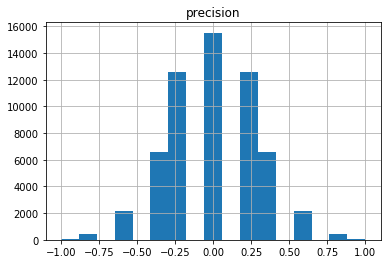

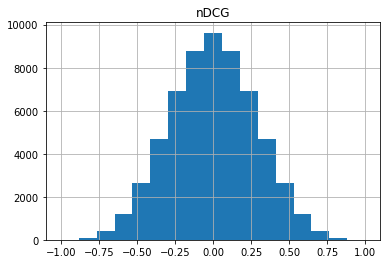

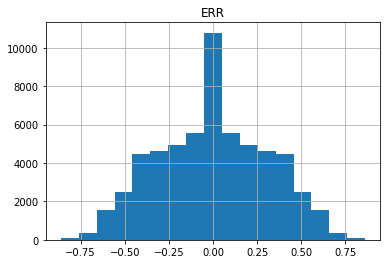

In [53]:
for c in df:
    plt.subplots()
    df[c].hist(bins=17)
    plt.title(c)

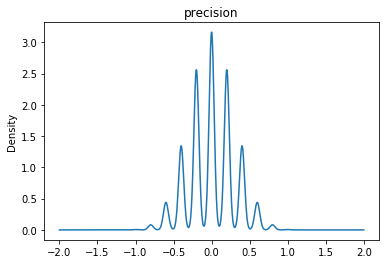

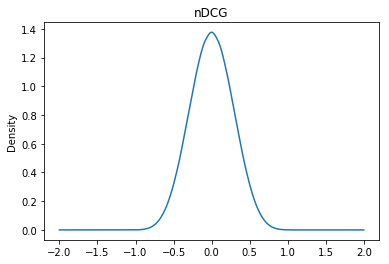

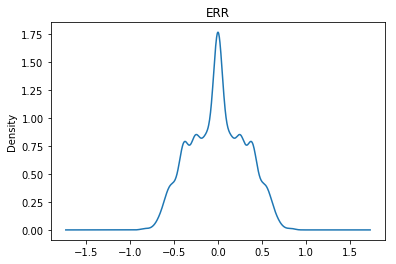

In [45]:
for c in df:
    plt.subplots()
    df[c].plot.kde()
    plt.title(c)

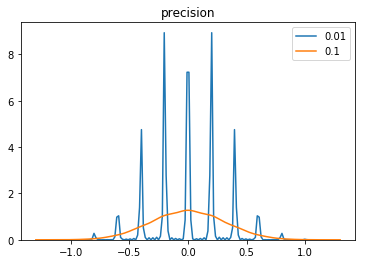

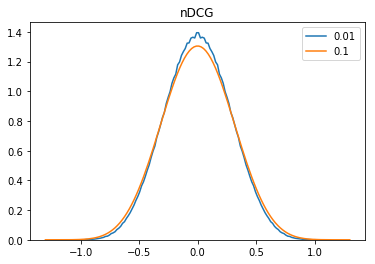

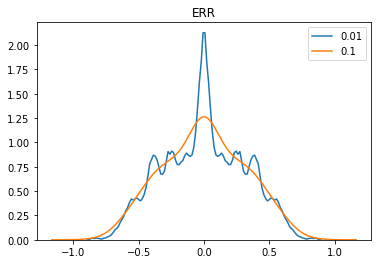

In [52]:
for c in df:
    plt.subplots()
    plt.title(c)
    sns.kdeplot(df[c], bw=0.01, label='0.01')
    sns.kdeplot(df[c], bw=0.1, label='0.1')
    plt.legend()
    plt.show()